In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import seaborn as sns

from statannotations.Annotator import Annotator


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_raw = r'Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\PLA\HCC827 cell culture'


In [7]:
from collections import defaultdict

data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir / 'OCT Cell Culture' / '3D_Whole'/ 'metadata' / 'imgs_sti.csv'
df_imgs = pd.read_csv(df_imgs_path)


# Initial statistics

In [22]:
PPI_save_path =  data_dir / 'OCT Cell Culture' /  '3D_Whole' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [23]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cell']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cell != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [24]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [25]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [26]:
# Filter out by maximum number of counts per cell
min_count = 20
max_count = 70

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

,Count_cell,Count_nuclei,Count_cyto
count,1595.000000,1595.000000,1595.000000
mean,74.311599,12.528527,61.783072
std,33.954691,37.398708,47.208984
min,21.000000,0.000000,-242.000000
25%,48.000000,0.000000,40.000000
50%,70.000000,0.000000,62.000000
75%,97.500000,0.000000,89.500000
max,270.000000,317.000000,270.000000


In [27]:
df_all = df_all[df_all['Count_cyto']>=0]

## Plots

In [20]:
def plot(plotting):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(7,4))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

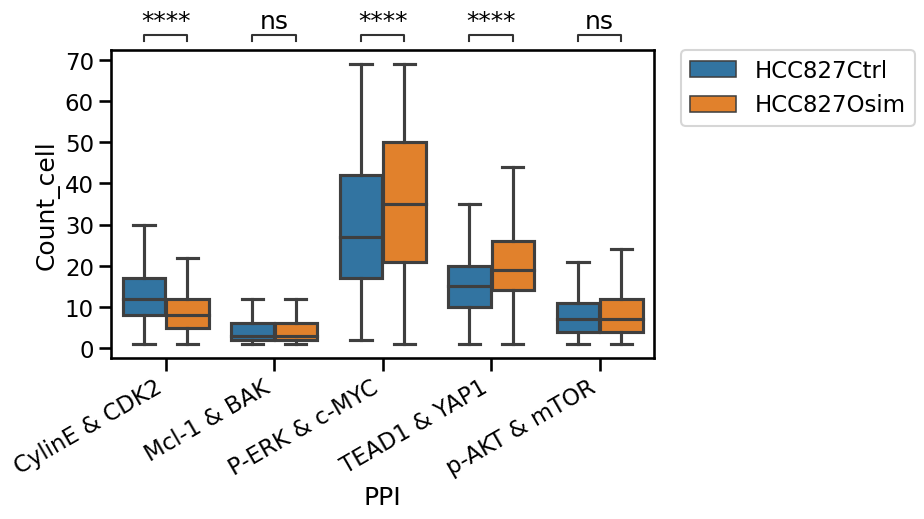

In [21]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

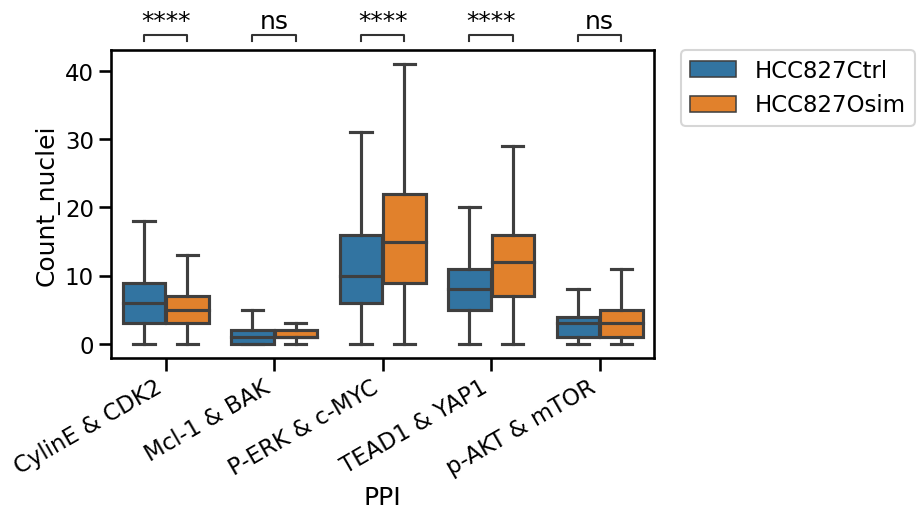

In [26]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

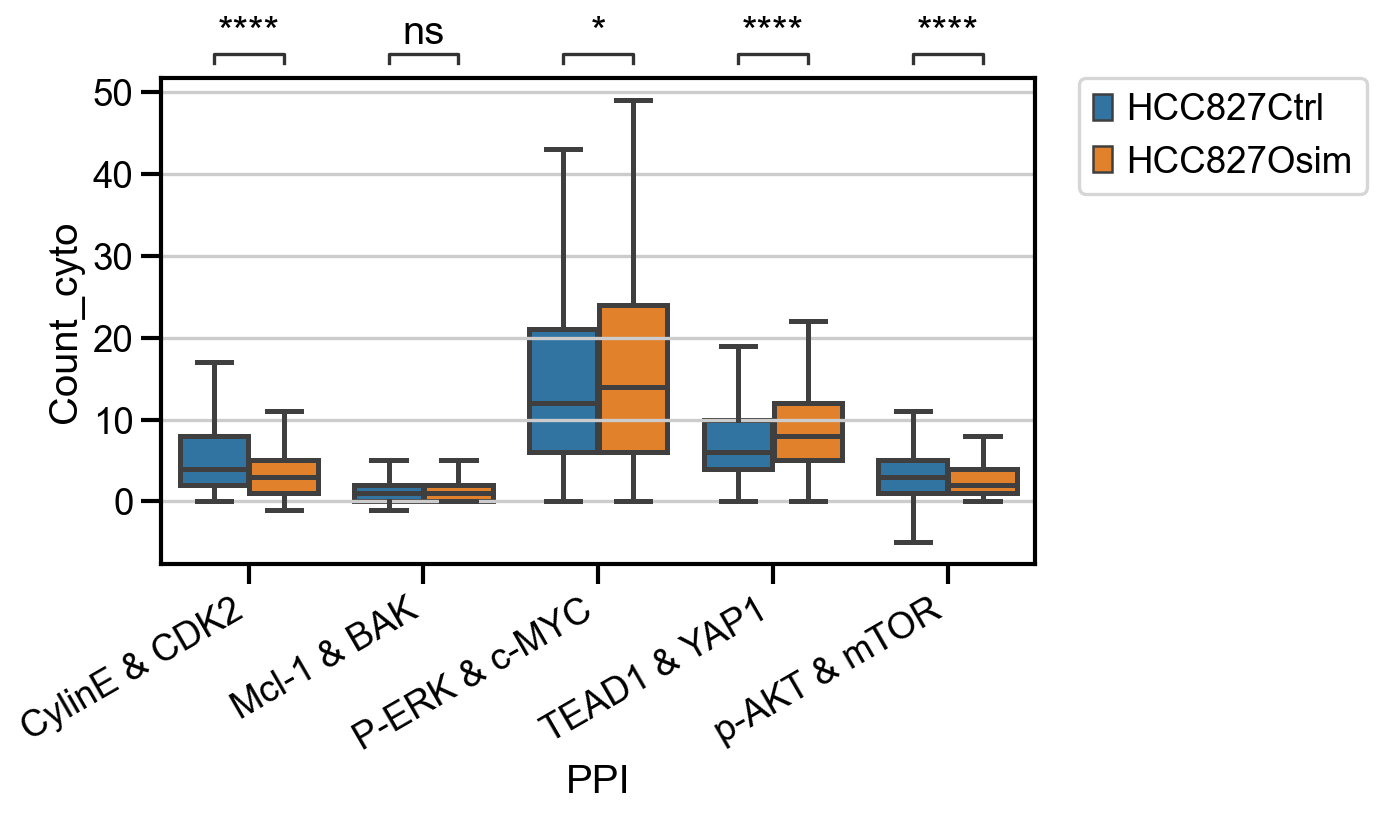

In [100]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:2.546e-01 U_stat=2.671e+05
CylinE & CDK2_Count_nuclei vs. CylinE & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.092e-07 U_stat=5.083e+05
P-ERK & c-MYC_Count_nuclei vs. P-ERK & c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:6.815e-05 U_stat=4.028e+05
TEAD1 & YAP1_Count_nuclei vs. TEAD1 & YAP1_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.211e-06 U_stat=5.081e+05
p-AKT & mTOR_Count_nuclei vs. p-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.662e-02 U_stat=3.979e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 

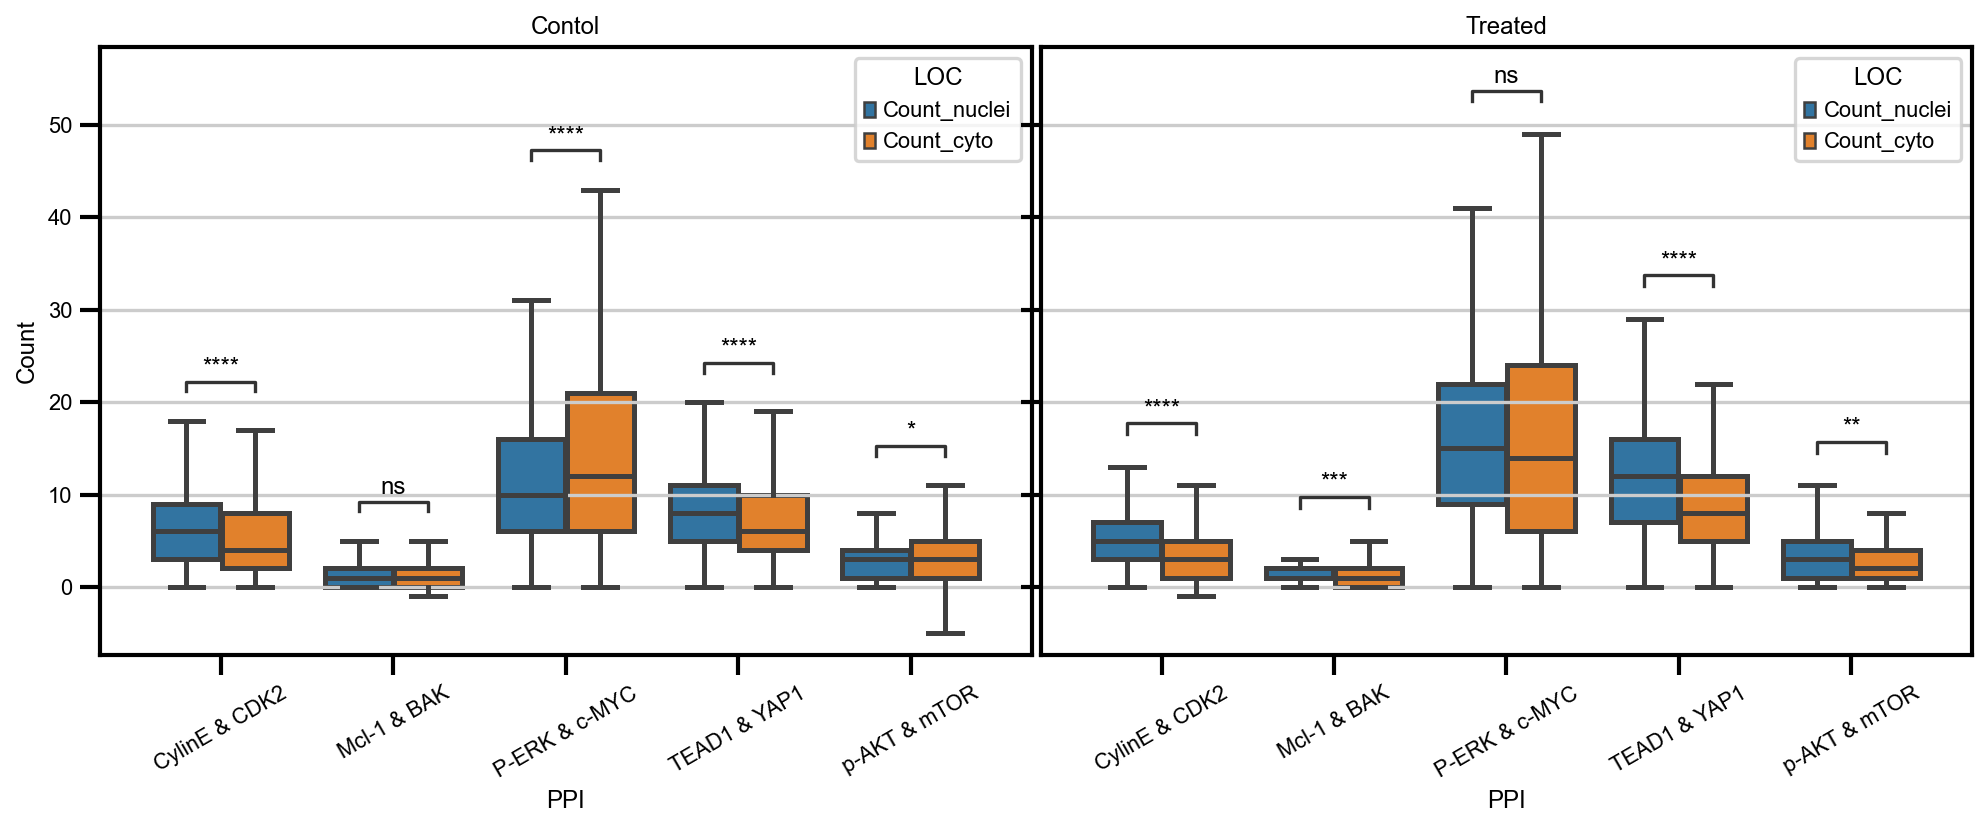

In [101]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'HCC827Ctrl']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == 'HCC827Osim']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

# Coexpression with other markers

## Extract mean expresion around PPI dots

In [7]:
from functools import partial

def read_mean_pixels(x, y, window_size, path):
    x_min = np.clip(x-window_size,a_min=0, a_max=None)
    x_max = x+window_size
    y_min = np.clip(y-window_size, a_min=0, a_max=None)
    y_max = y+window_size
    
    with h5py.File(path, "r") as f:
        pixels = f['imgs'][:, y_min:y_max, x_min:x_max]
    mean_expression = pixels.mean(axis=(1,2))
    return mean_expression
    
def extract(df, path, window_size=5):
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    
    # Read markers name 
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
    
    # Define partial and joblib
    read_partial = partial(read_mean_pixels, window_size=window_size, path=path)
    mean_expressions = Parallel(n_jobs=20)(delayed(read_partial)(i,j) for i,j in zip(y,x))
    
    # create dataframe
    _, indices = np.unique(markers, return_index=True)
    indices.sort()
    marker_unique = markers[indices]
    mean_expressions = np.stack(mean_expressions)
    df_exp = pd.DataFrame(mean_expressions[:, indices], columns=marker_unique)
    return df_exp

In [8]:
# Read PPI data
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)
df_fil = df[df.Cyto > 0]

In [9]:
# # Get Co-expression data
# PPI_exp_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI' / 'expression'

# group = df_fil.groupby(['Condition', 'FOV'])

# for name, df_group in group:
#     path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
#     df_expression = extract(df_group, path)
    
#     df_merged = pd.concat([df_group.reset_index(names='Original Index'), df_expression], axis=1, )
    
#     # Save coexpression
#     file_name = '_'.join(name)
#     save_path = PPI_exp_path / f'{file_name}.csv'
#     df_merged.to_csv(save_path)

## Analysis

In [6]:
def plot(plotting):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(15,3))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.barplot(**plotting, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [25]:
# Read PPI data
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)


In [26]:
df_exp.drop(['Phalloidin', 'Golph4', 'NBD-C6', 'COX IV'], axis=1, inplace=True)

In [27]:
# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :8]
df_marker_exp = df_exp.iloc[:, 8:]
# df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 8:] = df_norm

TEAD1 & YAP1


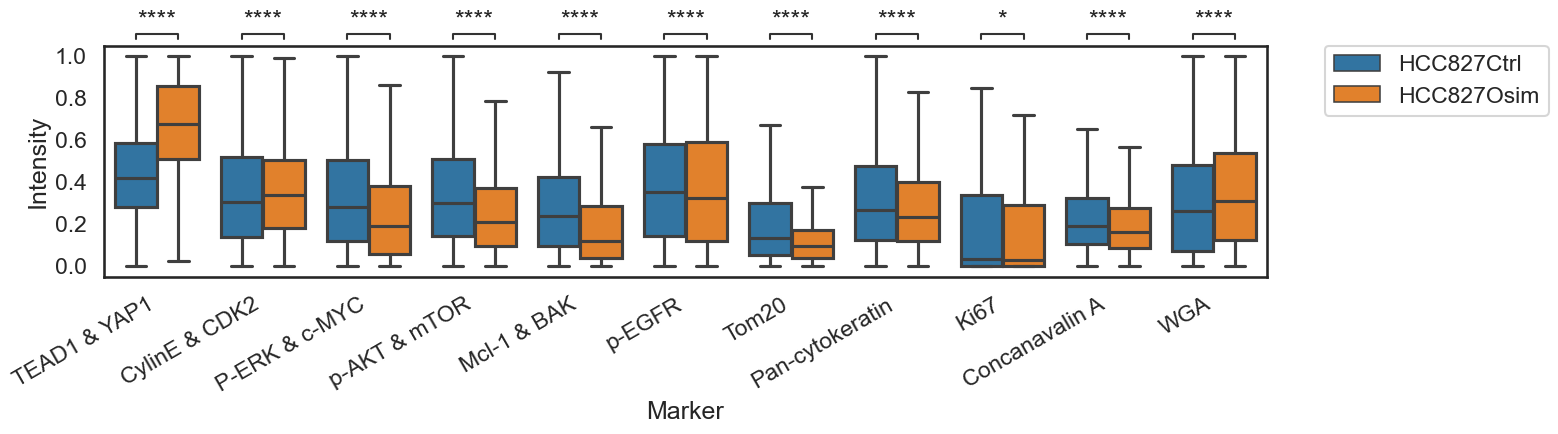

CylinE & CDK2


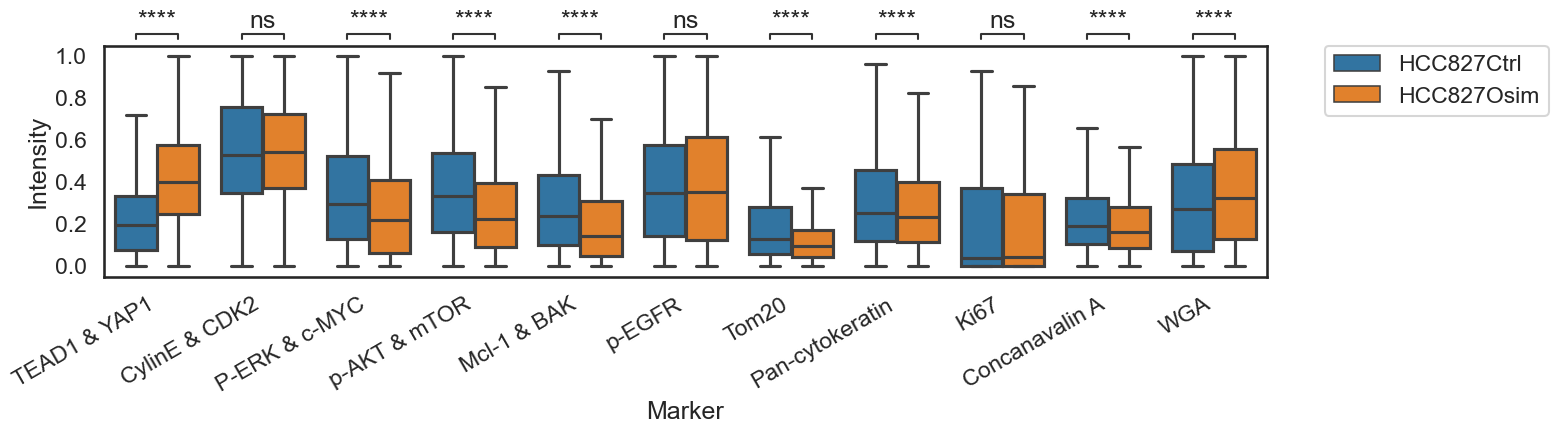

P-ERK & c-MYC


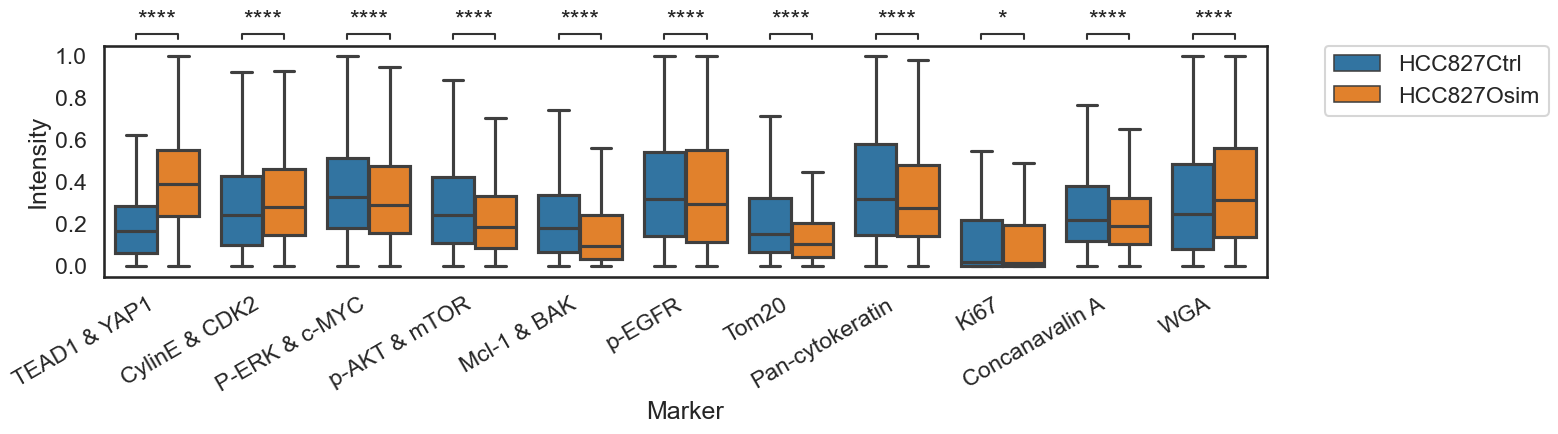

p-AKT & mTOR


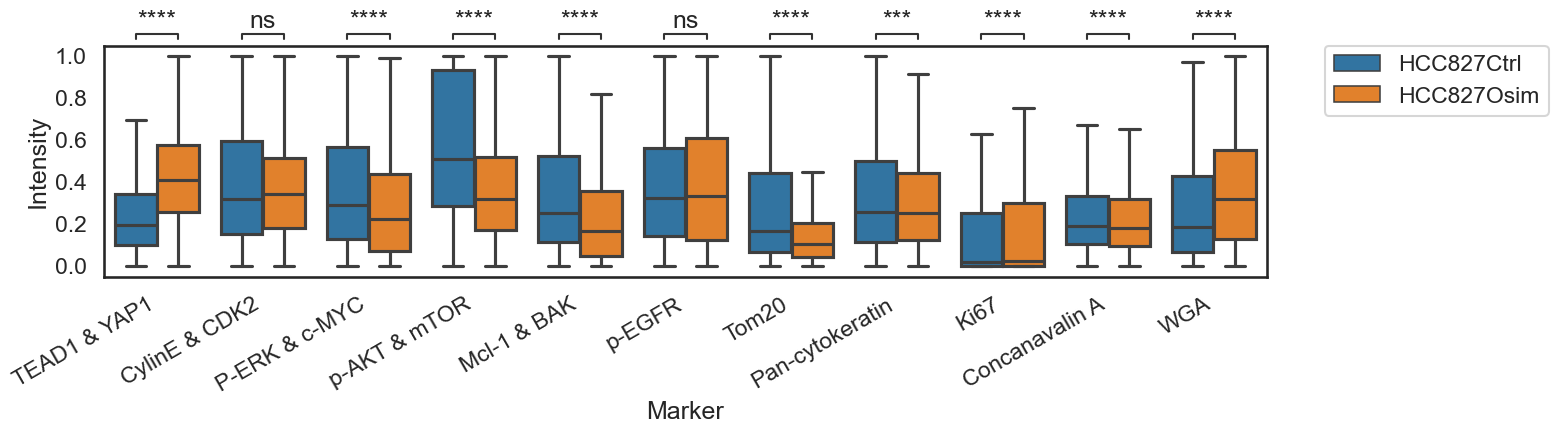

Mcl-1 & BAK


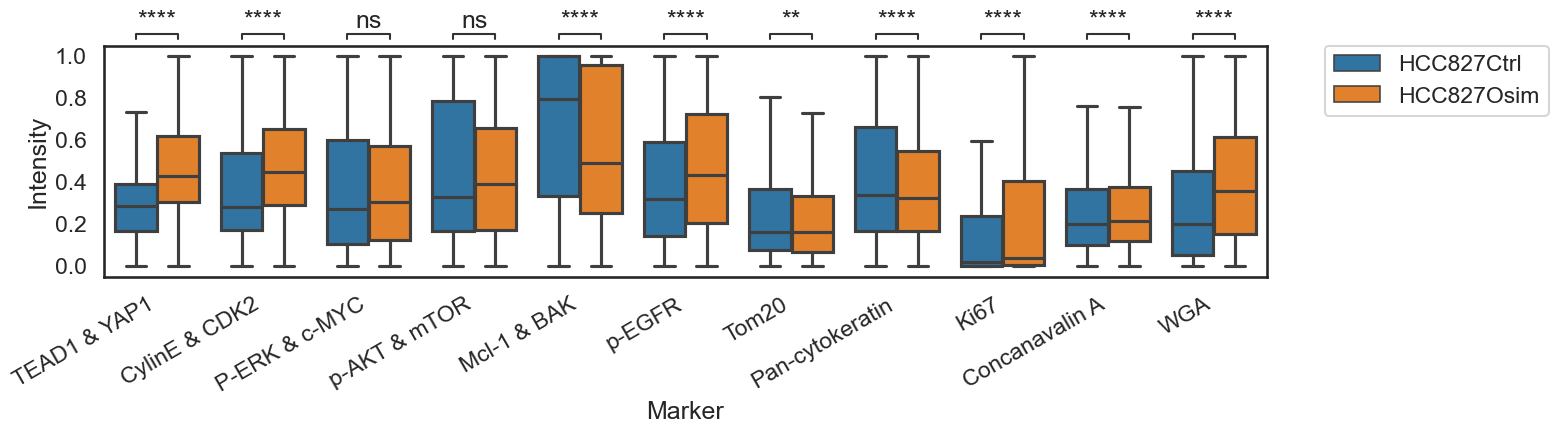

In [16]:
df_melt = df_exp.melt(id_vars = df_obs.columns, value_vars = df_norm.columns, var_name = 'Marker', value_name='Intensity')

with sns.axes_style("white"):
    for ppi in df_melt.PPI.unique():
        print(ppi)
        # Boxplot per cell
#         plotting = {
#             "data": df_melt[df_melt.PPI == ppi],
#             "x": "Marker",
#             "y": "Intensity",
#             "hue": "Condition"
#         }

#         plot(plotting)
            
        # Boxplot per cell
        plotting = {
            "data": df_melt[(df_melt.PPI == ppi) & (df_melt.Marker != 'Hoeschst')],
            "x": "Marker",
            "y": "Intensity",
            "hue": "Condition"
        }
        
        plot(plotting)
        plt.show()
        

TEAD1 & YAP1


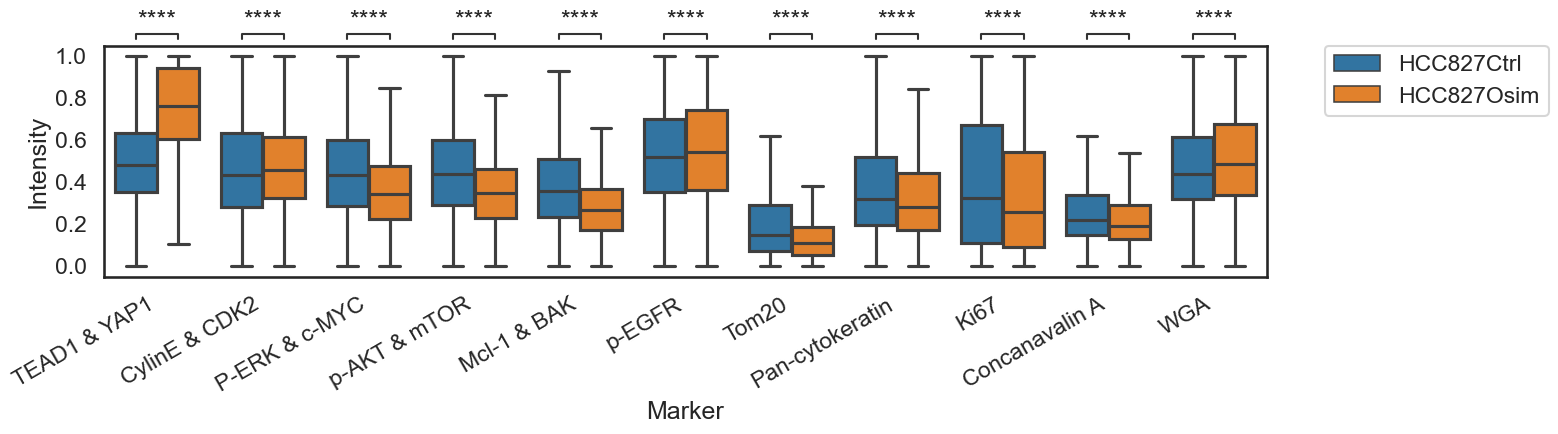

CylinE & CDK2


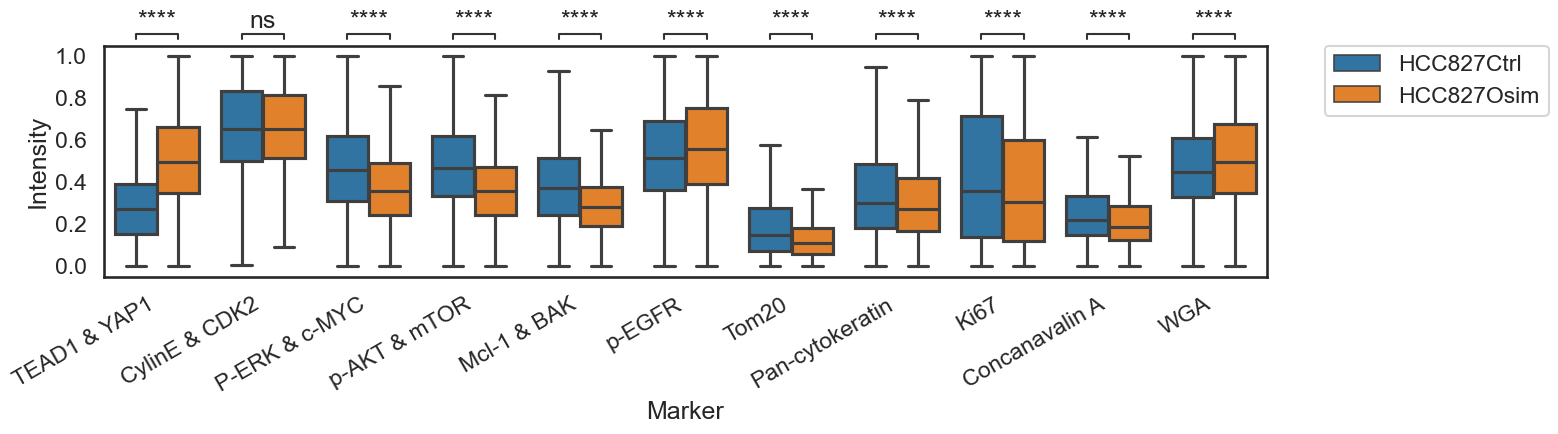

P-ERK & c-MYC


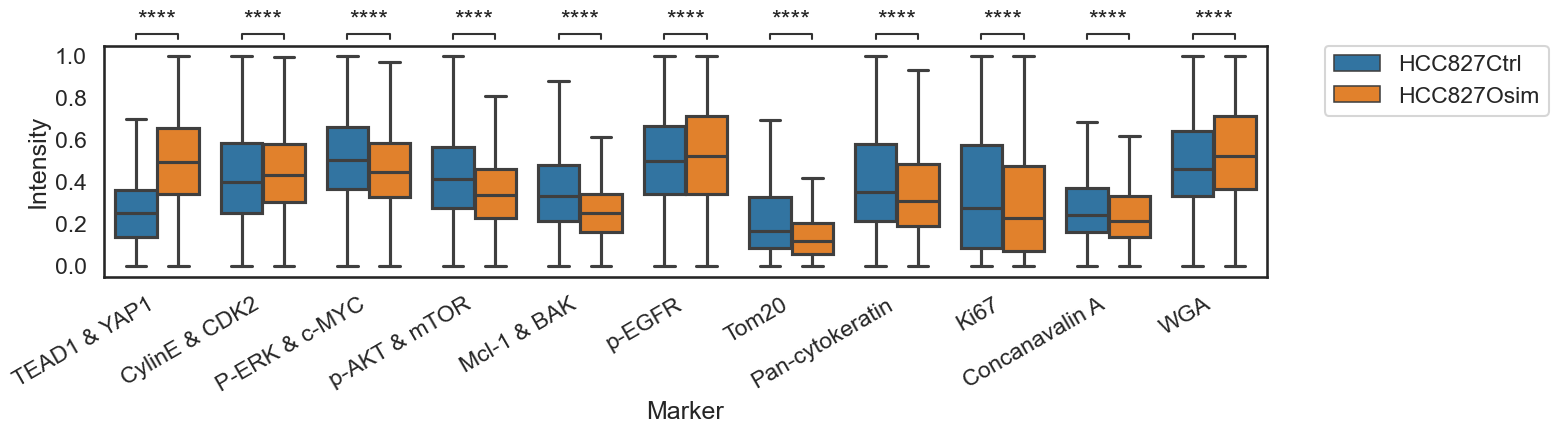

p-AKT & mTOR


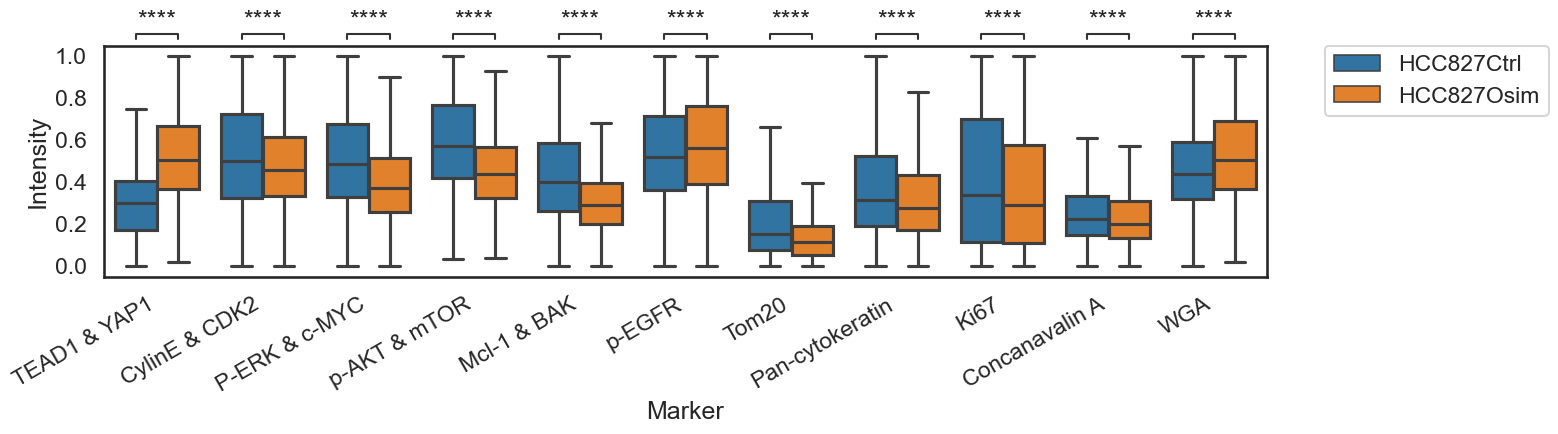

Mcl-1 & BAK


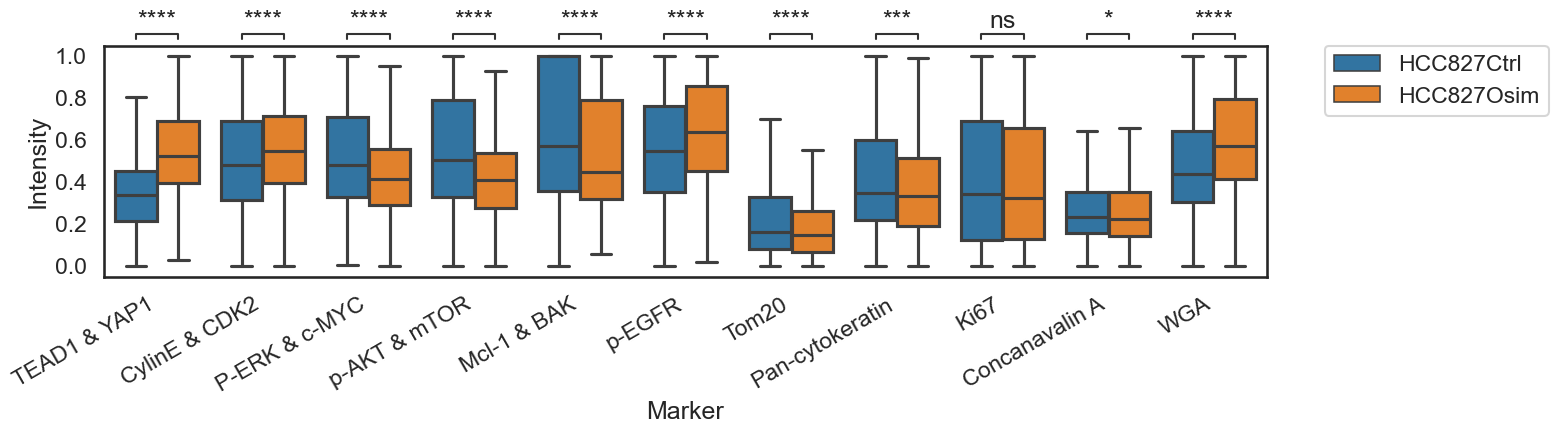

In [17]:
df_nuclei = df_melt[df_melt.Nuclei > 0]

with sns.axes_style("white"):
    for ppi in df_melt.PPI.unique():
        print(ppi)
        # Boxplot per cell
        plotting = {
            "data": df_nuclei[df_nuclei.PPI == ppi],
            "x": "Marker",
            "y": "Intensity",
            "hue": "Condition"
        }

#         plot(plotting)
            
        # Boxplot per cell
        plotting = {
            "data": df_nuclei[(df_nuclei.PPI == ppi) & (df_nuclei.Marker != 'Hoeschst')],
            "x": "Marker",
            "y": "Intensity",
            "hue": "Condition"
        }
        
        plot(plotting)
        
        plt.show()

TEAD1 & YAP1


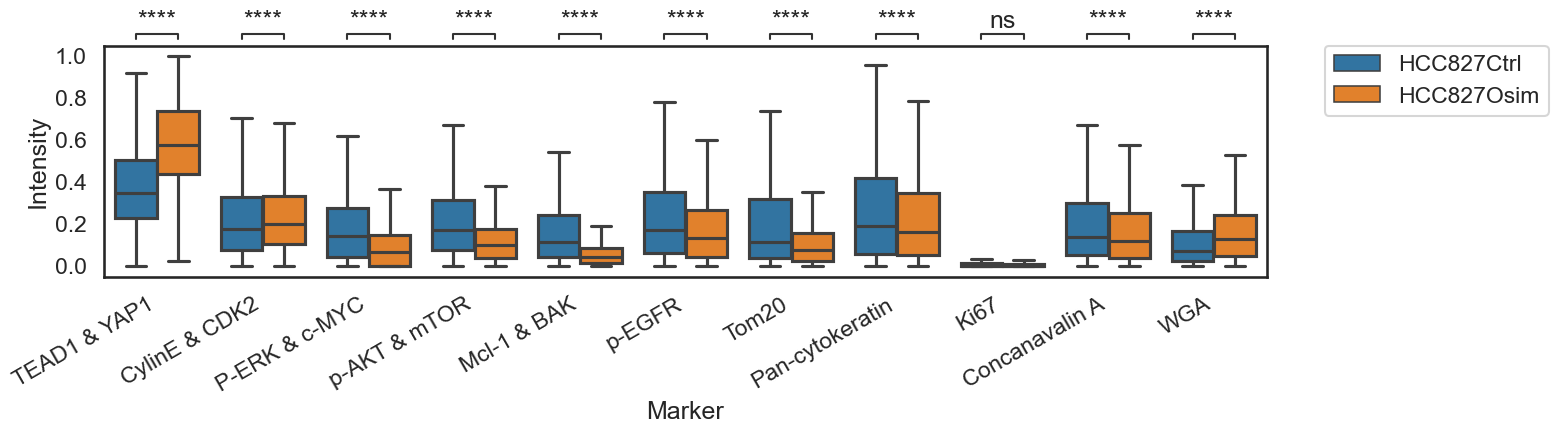

CylinE & CDK2


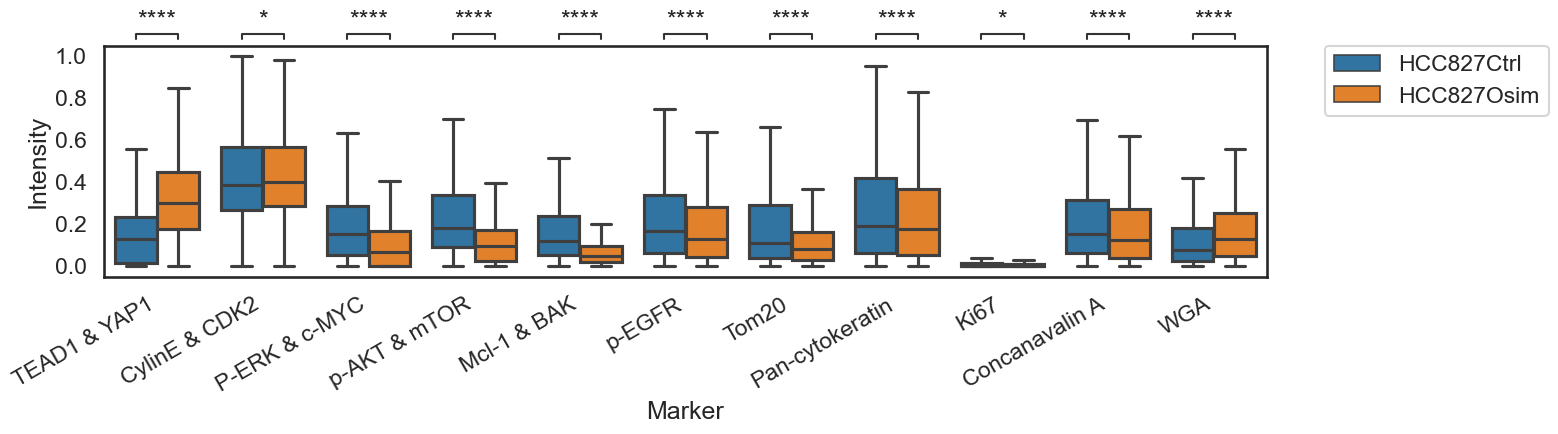

P-ERK & c-MYC


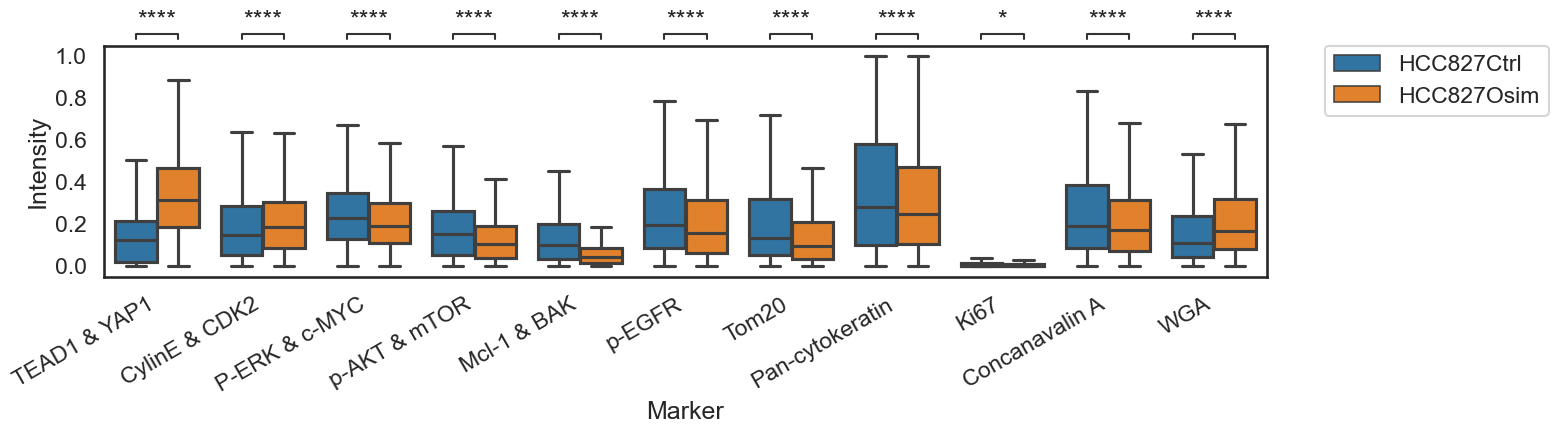

p-AKT & mTOR


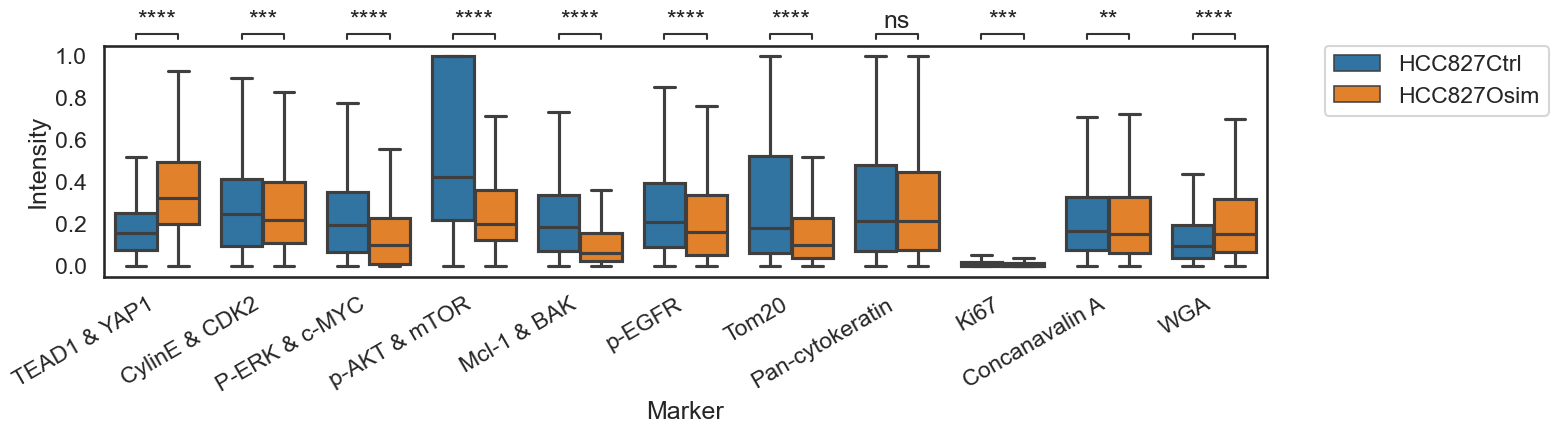

Mcl-1 & BAK


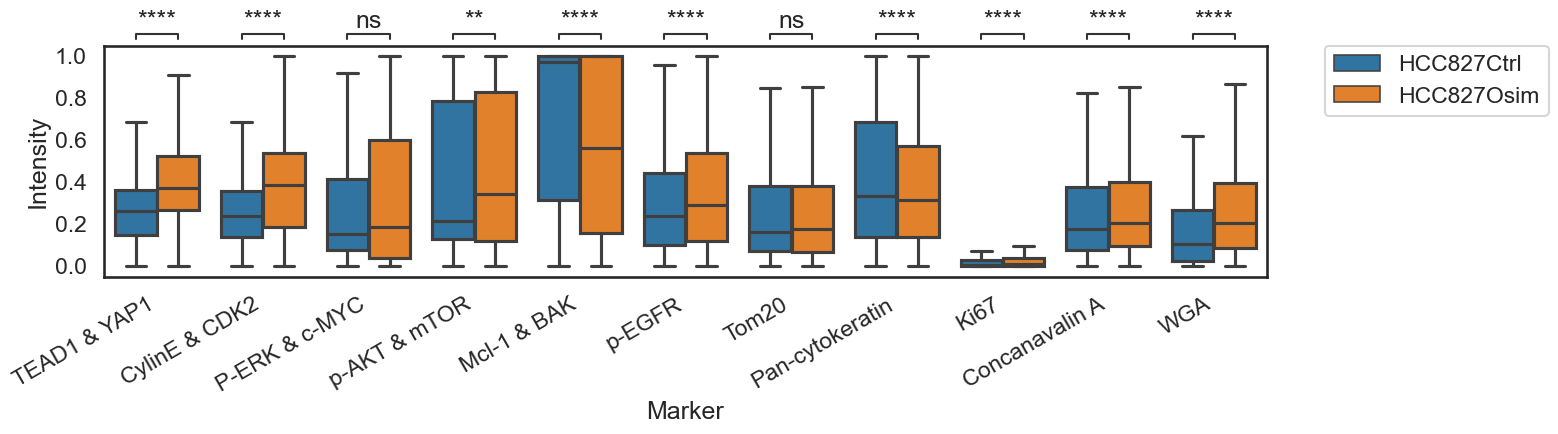

In [18]:
df_cyto = df_melt[df_melt.Nuclei ==  0]

with sns.axes_style("white"):
    for ppi in df_melt.PPI.unique():
        print(ppi)
        # Boxplot per cell
        plotting = {
            "data": df_cyto[df_cyto.PPI == ppi],
            "x": "Marker",
            "y": "Intensity",
            "hue": "Condition"
        }

        # plot(plotting)
            
        # Boxplot per cell
        plotting = {
            "data": df_cyto[(df_cyto.PPI == ppi) & (df_cyto.Marker != 'Hoeschst')],
            "x": "Marker",
            "y": "Intensity",
            "hue": "Condition"
        }
        
        plot(plotting)
        
        plt.show()

In [28]:
import anndata as ad
import scanpy as sc
sc.set_figure_params(transparent=True)

adata = ad.AnnData(df_norm.values, dtype=df_norm.values.dtype)
adata.var_names = df_marker_exp.columns.tolist()
adata.obs = df_obs
adata.obs['PPI'] = adata.obs['PPI'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.dendrogram(adata, groupby='PPI')

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


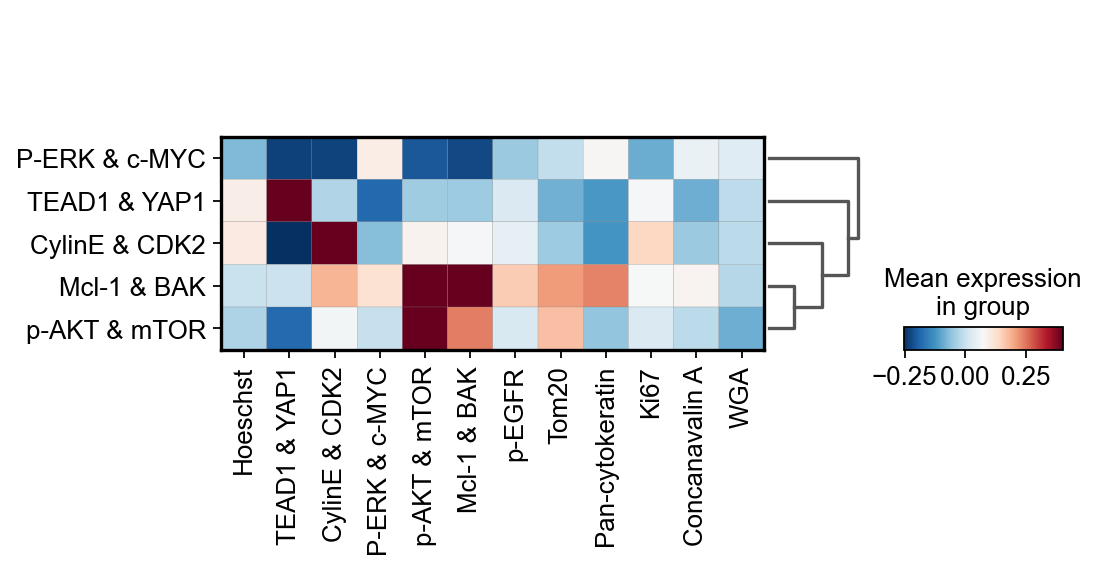

In [29]:
sc.pl.matrixplot(adata, adata.var_names, 'PPI', dendrogram=True, cmap='RdBu_r', vmax=0.4)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\traj\lib\contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


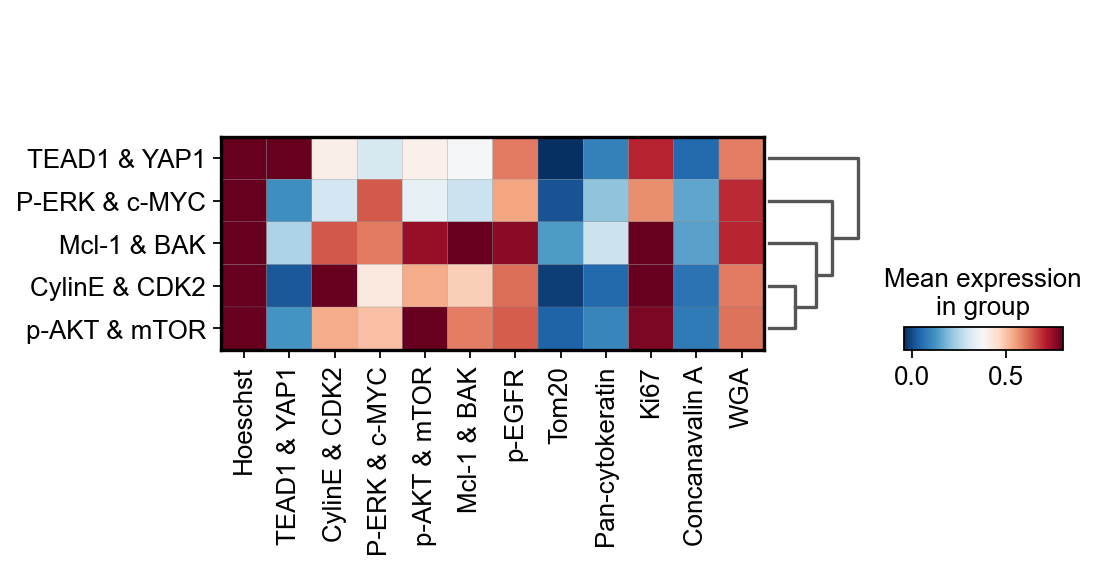

In [30]:
adata_subset = adata[adata.obs.Nuclei > 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r', vmax=0.8)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\traj\lib\contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


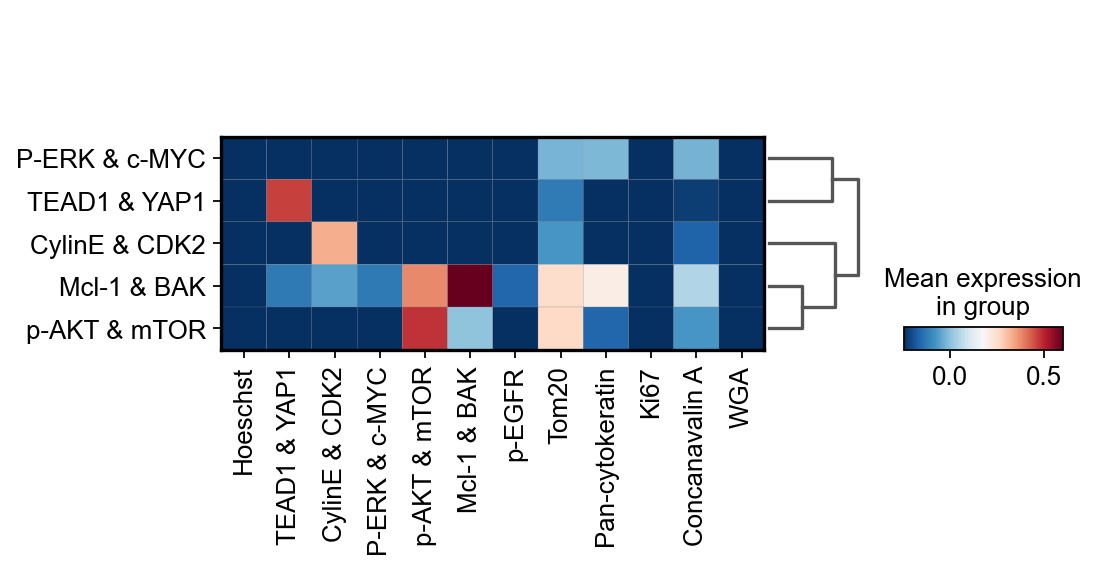

In [31]:
adata_subset = adata[adata.obs.Nuclei == 0]
sc.tl.dendrogram(adata_subset, groupby='PPI')

sc.pl.matrixplot(adata_subset, adata_subset.var_names, 'PPI', dendrogram=True, cmap='RdBu_r', vmin=-0.25, vmax=0.6)

### Analysis normalized by FOV

# Distribution as distance function from nuclei 

In [53]:
mask_filt_dir = data_dir / 'OCT Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [54]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    break

In [55]:
# Distance transform from 

In [56]:
from scipy import ndimage
import edt

# distance_map_cyto = ndimage.distance_transform_edt(mask_cyto)
# distance_map_nuclei = ndimage.distance_transform_edt(mask_nuclei)

distance_map_cyto = edt.edt2d(mask_cyto)
distance_map_nuclei = edt.edt2d(mask_nuclei)

ModuleNotFoundError: No module named 'edt'

In [ ]:
viewer = napari.view_image(distance_map_cyto, contrast_limits=[0, 255])
viewer.add_image(distance_map_nuclei, contrast_limits=[0, 255])
viewer.add_image(mask_cyto)
viewer.add_image(mask_nuclei)

In [ ]:
distance_comb = np.where(distance_map_nuclei>0, distance_map_nuclei, -distance_map_cyto)

In [ ]:
viewer = napari.view_image(distance_comb, contrast_limits=[-255, 255])
viewer.add_image(mask_cyto)
viewer.add_image(mask_nuclei)